# Gradient Descent with Minibatch and Momentum

In [2]:
import numpy as np

class MomentumGradientDescent:
    def __init__(
        self,
        learning_rate=0.001,
        momentum=0.9,
        max_iters=1e4,
        epsilon=1e-8,
        batch_size=32,
        record_history=False,
    ):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.prev_delta_w = None
        if record_history:
            # to store the weight history for visualization
            self.w_history = []

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        N, D = x.shape
        self.prev_delta_w = np.zeros(w.shape)
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            for i in range(0, N, self.batch_size):
                if x.ndim == 1:
                    batch_x = x[i:i + self.batch_size]
                else:
                    batch_x = x[i:i + self.batch_size, :]

                if y.ndim == 1:
                    batch_y = y[i:i + self.batch_size]
                else:
                    batch_y = y[i:i + self.batch_size, :]

                # compute the gradient with present weight
                grad = gradient_fn(batch_x, batch_y, w)
                delta_w = self.get_delta_w(grad)

                # weight update step
                w = w - self.learning_rate * delta_w
                if self.record_history:
                    self.w_history.append(w)
            t += 1
        return w

    def get_delta_w(self, grad):
        beta = self.momentum
        delta_w = beta * self.prev_delta_w + (1 - beta) * grad
        self.prev_delta_w = delta_w

        return delta_w

# Softmax Regression

Below is our implementation of the Softmax Regression model. Class labels and predictions are one-hot encoded.

In [3]:
import numpy as np

# from the given Colab code
logistic = lambda z: 1./ (1 + np.exp(-z))  

class SoftmaxRegression:

    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
            
    def fit(self, x, y, C, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        
        def to_onehot(a):
            return np.eye(C)[a]
        
        def gradient(x, y, w):
            N, D = x.shape
            # yh: N x C
            yh = self.softmax(np.dot(x, w))
            # both are N x C
            yh = to_onehot(self.to_classlabel(yh))
            y = to_onehot(y)
            
            grad = np.dot(x.T, yh - y) / N
            return grad
        
        # initialize all weights to random values
        w0 = np.random.rand(D,C) 
        # run the optimizer to get the optimal weights
        self.w = optimizer.run(gradient, x, y, w0)
        return self
    
    def softmax(self, z):
        # to prevent overflow/underflow
        z = z - np.max(z, axis=-1, keepdims=True)
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def to_classlabel(self, z):
        return z.argmax(axis=1)
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        # convert from 1D to 2D
        x = np.reshape(x, (1, -1))
        yh = self.softmax(np.dot(x, self.w))
        return self.to_classlabel(yh)[0]
        

# Validation of Model

Throughout the code below, validation is performed using 5-fold cross-validation. Here we define some helper methods which are used in the following sections below.

In [4]:
import math

def k_fold_splitter(fold, dataset):
    """
    Returns 2 datasets (training and validation)
    """
    start = math.floor(fold*(dataset.shape[0]/5))
    end = math.floor((fold+1)*(dataset.shape[0]/5))

    training = np.delete(dataset, slice(start, end-1), axis=0)
    validation = dataset[start:end-1]

    return training, validation

def calculate_model_accuracy(x, y, C, learning_rate, momentum, batch_size, max_iters=10000):
    """
    Helper method to calculate the accuracy of our implemented Softmax
    Regression model for a given set of inputs, labels, and hyper-parameters
    """
    accuracies = []
    # do 5-fold cross-validation
    for fold_num in range(5):
        train_data, validation_data = k_fold_splitter(fold_num, x)
        train_labels, validation_labels = k_fold_splitter(fold_num, y)

        optimizer = MomentumGradientDescent(
            learning_rate=learning_rate, 
            momentum=momentum, 
            batch_size=batch_size, 
            max_iters=max_iters,
        )
        model = SoftmaxRegression(add_bias=False)
        model.fit(train_data, train_labels, C, optimizer)

        num_misclassified = 0
        # calculate the accuracy
        for i in range(len(validation_data)):
            prediction = model.predict(validation_data[i, :])
            if prediction != validation_labels[i]:
                num_misclassified += 1

        misclassification_rate = num_misclassified / len(validation_labels)
        accuracies.append(1 - misclassification_rate)
        
    return np.average(accuracies)
    

# Grid Search to Find Good Hyper-Parameters

### Digits Dataset

First we do a grid search to find a good set of hyper-parameters (learning rate, momentum, batch size). This will give us a reference point for the model's performance which we can compare to as we change individual hyper-parameters. These parameters are not optimal since our grid search does not try an extensive set of combinations, but they are at least a good starting point. We kept the number of combinations on the smaller side since each loop iteration is fairly expensive in terms of computation time.

> Note: these all take a fairly long time to run!

In [192]:
from sklearn.datasets import load_digits

digits = load_digits()
x, y = digits.data, digits.target

C = 10
max_accuracy = 0
best_learning_rate = 0
best_momentum = 0
best_batch_size = x.shape[0]

# grid search to find good hyper-parameters
for learning_rate in np.linspace(0.0001, 0.2, 11):
    for momentum in np.linspace(0.5, 0.99, 11):
        accuracy = calculate_model_accuracy(x, y, C, learning_rate, momentum, x.shape[0])
        if accuracy > max_accuracy:
            print(accuracy, end = ', ')
            max_accuracy = accuracy
            best_learning_rate = learning_rate
            best_momentum = momentum
            
for batch_size in range(1, x.shape[0], 64):
    accuracy = calculate_model_accuracy(x, y, C, best_learning_rate, best_momentum, batch_size)
    if accuracy > max_accuracy:
        print(accuracy, end = ' [BATCH], ')
        max_accuracy = accuracy
        best_batch_size = batch_size
            
print("\n\nBest Accuracy: {}".format(max_accuracy))  
print("Best Learning Rate: {}".format(best_learning_rate))  
print("Best Momentum: {}".format(best_momentum))  
print("Best Batch Size: {}".format(best_batch_size))  

0.7109319805169543, 0.752257201101757, 0.8711037798976051, 0.8783570128071458, 0.8867228956910103, 0.887279998755077, 0.9090334728684584, 0.9118314374192746, 0.9190877826364356, 0.9196417733928822, 0.9201973203031388, 0.9202051010721901 [BATCH], 0.9218701856491496 [BATCH], 0.9246572571232938 [BATCH], 

Best Accuracy: 0.9246572571232938
Best Learning Rate: 0.14003
Best Momentum: 0.99
Best Batch Size: 897


### Wine Dataset

Similar to above, we first do a grid search to find a good set of hyper-parameters as a reference point for the model's performance.

In [193]:
from sklearn.datasets import load_wine

wine = load_wine()
x, y = wine.data, wine.target

C = 3
max_accuracy = 0
best_learning_rate = 0
best_momentum = 0
best_batch_size = x.shape[0]

# grid search to find good hyper-parameters
for learning_rate in np.linspace(0.0001, 0.2, 11):
    for momentum in np.linspace(0.5, 0.99, 11):
        accuracy = calculate_model_accuracy(x, y, C, learning_rate, momentum, x.shape[0])
        if accuracy > max_accuracy:
            print(accuracy, end=', ')
            max_accuracy = accuracy
            best_learning_rate = learning_rate
            best_momentum = momentum
            
# use an increment of 16 instead of 64 since this dataset is much smaller
for batch_size in range(1, x.shape[0], 16):
    accuracy = calculate_model_accuracy(x, y, C, best_learning_rate, best_momentum, batch_size)
    if accuracy > max_accuracy:
        print(accuracy, end=' [BATCH], ')
        max_accuracy = accuracy
        best_batch_size = batch_size
            
print("\n\nBest Accuracy: {}".format(max_accuracy))
print("Best Learning Rate: {}".format(best_learning_rate))
print("Best Momentum: {}".format(best_momentum))
print("Best Batch Size: {}".format(best_batch_size))

0.7129411764705882, 0.7914285714285715, 0.8729411764705881, 0.9067226890756303, 0.918655462184874, 0.9305882352941175, 0.9361344537815126, 0.9418487394957984, 0.9536134453781513, 

Best Accuracy: 0.9536134453781513
Best Learning Rate: 0.14003
Best Momentum: 0.696
Best Batch Size: 178


# Analysis: Varying Individual Hyper-Parameters

Now that we have a good set of hyper-parameters, we can observe how the accuracy of the Softmax Regression model changes as the value of one hyper-parameter is varied.

### Learning Rate

In [5]:
# store hyper-parameter values here for use below
digits_learning_rate = 0.14003
digits_momentum = 0.99
digits_batch_size = 897

wine_learning_rate = 0.14003
wine_momentum = 0.696
wine_batch_size = 178

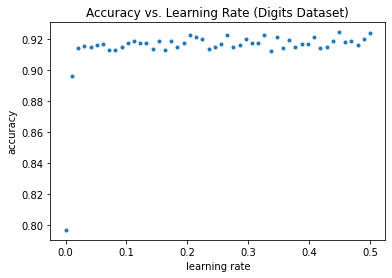

In [203]:
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

digits = load_digits()
x, y = digits.data, digits.target

C = 10
digits_accuracies = []
learning_rates = np.linspace(0.0001, 0.5, 50)

for learning_rate in learning_rates:
    # using the hyper-parameter values obtained from grid search
    accuracy = calculate_model_accuracy(x, y, C, learning_rate, digits_momentum, digits_batch_size)
    digits_accuracies.append(accuracy)

# plot for accuracy vs. learning rate on digits dataset
plt.plot(learning_rates, digits_accuracies, '.')
plt.title('Accuracy vs. Learning Rate (Digits Dataset)')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.show()

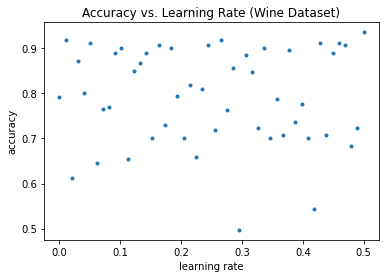

In [202]:
wine = load_wine()
x, y = wine.data, wine.target

C = 3
wine_accuracies = []
learning_rates = np.linspace(0.0001, 0.5, 50)

for learning_rate in learning_rates:
    # using the hyper-parameter values obtained from grid search
    accuracy = calculate_model_accuracy(x, y, C, learning_rate, wine_momentum, wine_batch_size)
    wine_accuracies.append(accuracy)

# plot for accuracy vs. learning rate on wine dataset
plt.plot(learning_rates, wine_accuracies, '.')
plt.title('Accuracy vs. Learning Rate (Wine Dataset)')
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.show()

### Momentum

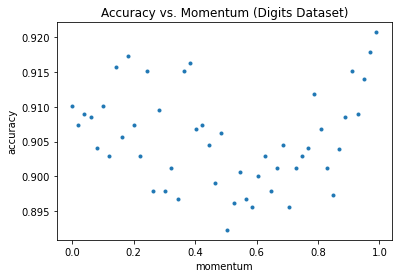

In [204]:
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

digits = load_digits()
x, y = digits.data, digits.target

C = 10
digits_accuracies = []
momentums = np.linspace(0, 0.99, 50)

for momentum in momentums:
    # using the hyper-parameter values obtained from grid search
    accuracy = calculate_model_accuracy(x, y, C, digits_learning_rate, momentum, digits_batch_size)
    digits_accuracies.append(accuracy)

# plot for accuracy vs. momentum on digits dataset
plt.plot(momentums, digits_accuracies, '.')
plt.title('Accuracy vs. Momentum (Digits Dataset)')
plt.xlabel('momentum')
plt.ylabel('accuracy')
plt.show()

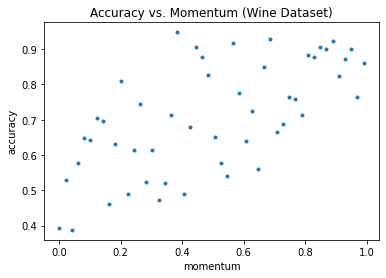

In [205]:
wine = load_wine()
x, y = wine.data, wine.target

C = 3
wine_accuracies = []
momentums = np.linspace(0, 0.99, 50)

for momentum in momentums:
    # using the hyper-parameter values obtained from grid search
    accuracy = calculate_model_accuracy(x, y, C, wine_learning_rate, momentum, wine_batch_size)
    wine_accuracies.append(accuracy)

# plot for accuracy vs. momentum on wine dataset
plt.plot(momentums, wine_accuracies, '.')
plt.title('Accuracy vs. Momentum (Wine Dataset)')
plt.xlabel('momentum')
plt.ylabel('accuracy')
plt.show()

### Batch Size

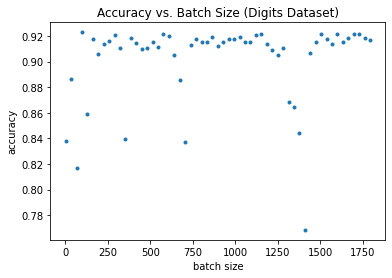

In [207]:
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

digits = load_digits()
x, y = digits.data, digits.target

C = 10
digits_accuracies = []
batch_sizes = range(1, x.shape[0], 32)

for batch_size in batch_sizes:
    # using the hyper-parameter values obtained from grid search
    accuracy = calculate_model_accuracy(x, y, C, digits_learning_rate, digits_momentum, batch_size)
    digits_accuracies.append(accuracy)

# plot for accuracy vs. batch size on digits dataset
plt.plot(batch_sizes, digits_accuracies, '.')
plt.title('Accuracy vs. Batch Size (Digits Dataset)')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.show()

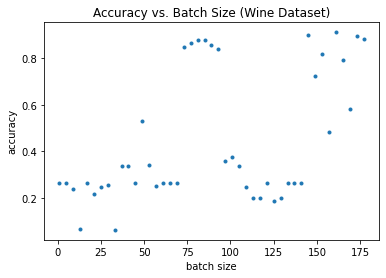

In [208]:
wine = load_wine()
x, y = wine.data, wine.target

C = 3
wine_accuracies = []
batch_sizes = range(1, x.shape[0], 4)

for batch_size in batch_sizes:
    # using the hyper-parameter values obtained from grid search
    accuracy = calculate_model_accuracy(x, y, C, wine_learning_rate, wine_momentum, batch_size)
    wine_accuracies.append(accuracy)

# plot for accuracy vs. batch size on wine dataset
plt.plot(batch_sizes, wine_accuracies, '.')
plt.title('Accuracy vs. Batch Size (Wine Dataset)')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.show()

### Maximum Iterations

Here we generally expect the accuracy to improve as the maximum number of allowed iterations increases.

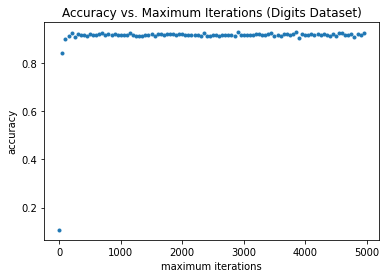

In [209]:
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

digits = load_digits()
x, y = digits.data, digits.target

C = 10
digits_accuracies = []
max_iterations = range(1, 5000, 50)

for max_iters in max_iterations:
    # using the hyper-parameter values obtained from grid search
    accuracy = calculate_model_accuracy(x, y, C, digits_learning_rate, digits_momentum, digits_batch_size, max_iters)
    digits_accuracies.append(accuracy)

# plot for accuracy vs. max iters on digits dataset
plt.plot(max_iterations, digits_accuracies, '.')
plt.title('Accuracy vs. Maximum Iterations (Digits Dataset)')
plt.xlabel('maximum iterations')
plt.ylabel('accuracy')
plt.show()

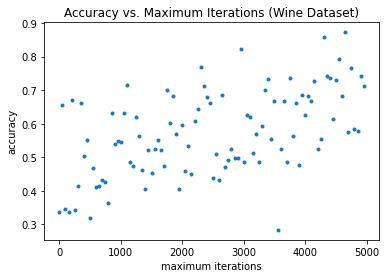

In [210]:
wine = load_wine()
x, y = wine.data, wine.target

C = 3
wine_accuracies = []
max_iterations = range(1, 5000, 50)

for max_iters in max_iterations:
    # using the hyper-parameter values obtained from grid search
    accuracy = calculate_model_accuracy(x, y, C, wine_learning_rate, wine_momentum, wine_batch_size, max_iters)
    wine_accuracies.append(accuracy)

# plot for accuracy vs. maximum iterations on wine dataset
plt.plot(max_iterations, wine_accuracies, '.')
plt.title('Accuracy vs. Maximum Iterations (Wine Dataset)')
plt.xlabel('maximum iterations')
plt.ylabel('accuracy')
plt.show()

# Comparison Against Other Classifiers

Now we can compare our model to an off-the-shelf classifier to see how the performance compares on the digits dataset. We will be comparing against the Ridge Regression and Logistic Regression models from SciKit Learn.

### Digits Dataset Comparison

In [8]:
from sklearn.datasets import load_digits
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

digits = load_digits()
x, y = digits.data, digits.target

C = 10
# using the hyper-parameters obtained from grid search
softmax_accuracy = calculate_model_accuracy(x, y, C, digits_learning_rate, digits_momentum, digits_batch_size)

# Ridge Regression
ridge_model_accuracies = []
for fold_num in range(5):
    train_data, validation_data = k_fold_splitter(fold_num, x)
    train_labels, validation_labels = k_fold_splitter(fold_num, y)

    ridge_model = RidgeClassifier(max_iter=10000)
    ridge_model.fit(train_data, train_labels)

    ridge_model_accuracies.append(ridge_model.score(validation_data, validation_labels))
    
# Logistic Regression
logistic_model_accuracies = []
for fold_num in range(5):
    train_data, validation_data = k_fold_splitter(fold_num, x)
    train_labels, validation_labels = k_fold_splitter(fold_num, y)

    logistic_model = LogisticRegression(multi_class="multinomial", max_iter=10000)
    logistic_model.fit(train_data, train_labels)

    logistic_model_accuracies.append(logistic_model.score(validation_data, validation_labels))
    
# Multinomial Naive Bayes
nb_model_accuracies = []
for fold_num in range(5):
    train_data, validation_data = k_fold_splitter(fold_num, x)
    train_labels, validation_labels = k_fold_splitter(fold_num, y)

    nb_model = MultinomialNB()
    nb_model.fit(train_data, train_labels)

    nb_model_accuracies.append(nb_model.score(validation_data, validation_labels))

print("Softmax Regression Accuracy: {}".format(softmax_accuracy))
print("Ridge Regression (SKLearn) Accuracy: {}".format(np.average(ridge_model_accuracies)))
print("Logistic Regression (SKLearn) Accuracy: {}".format(np.average(logistic_model_accuracies)))
print("Multinomial Naive Bayes (SKLearn) Accuracy: {}".format(np.average(nb_model_accuracies)))

Softmax Regression Accuracy: 0.9112618851247257
Ridge Regression (SKLearn) Accuracy: 0.8889653133315697
Logistic Regression (SKLearn) Accuracy: 0.918524454957128
Multinomial Naive Bayes (SKLearn) Accuracy: 0.8716826691150154


### Wine Dataset Comparison

We can do the same comparison on the wine dataset. This is done below.

Since the wine dataset only contains 178 samples, our model is trained on a fairly small number of instances in this case. This causes the reported accuracy to vary between roughly 60-90%, which is quite dramatic. If the wine dataset contained more samples, we believe this variation would be smaller.

In [10]:
from sklearn.datasets import load_wine
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

wine = load_wine()
x, y = wine.data, wine.target

C = 3
# using the hyper-parameters obtained from grid search
softmax_accuracy = calculate_model_accuracy(x, y, C, wine_learning_rate, wine_momentum, wine_batch_size)

# Ridge Regression
ridge_model_accuracies = []
for fold_num in range(5):
    train_data, validation_data = k_fold_splitter(fold_num, x)
    train_labels, validation_labels = k_fold_splitter(fold_num, y)

    ridge_model = RidgeClassifier(max_iter=10000)
    ridge_model.fit(train_data, train_labels)

    ridge_model_accuracies.append(ridge_model.score(validation_data, validation_labels))
    
# Logistic Regression
logistic_model_accuracies = []
for fold_num in range(5):
    train_data, validation_data = k_fold_splitter(fold_num, x)
    train_labels, validation_labels = k_fold_splitter(fold_num, y)

    logistic_model = LogisticRegression(multi_class="multinomial", max_iter=10000)
    logistic_model.fit(train_data, train_labels)

    logistic_model_accuracies.append(logistic_model.score(validation_data, validation_labels))

# Gaussian Naive Bayes
nb_model_accuracies = []
for fold_num in range(5):
    train_data, validation_data = k_fold_splitter(fold_num, x)
    train_labels, validation_labels = k_fold_splitter(fold_num, y)

    nb_model = GaussianNB()
    nb_model.fit(train_data, train_labels)

    nb_model_accuracies.append(nb_model.score(validation_data, validation_labels))
    
print("Softmax Regression Accuracy: {}".format(softmax_accuracy))
print("Ridge Regression (SKLearn) Accuracy: {}".format(np.average(ridge_model_accuracies)))
print("Logistic Regression (SKLearn) Accuracy: {}".format(np.average(logistic_model_accuracies)))
print("Gaussian Naive Bayes (SKLearn) Accuracy: {}".format(np.average(nb_model_accuracies)))

Softmax Regression Accuracy: 0.9357983193277312
Ridge Regression (SKLearn) Accuracy: 0.9421848739495797
Logistic Regression (SKLearn) Accuracy: 0.9359663865546219
Gaussian Naive Bayes (SKLearn) Accuracy: 0.9594957983193277
